<a href="https://colab.research.google.com/github/Guiandreis/pneumonia_detection/blob/main/Pneumonia_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT KAGGLE DATASET AND EXTRACT

In [ ]:
#https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
!pip install -q kaggle

You should consider upgrading via the 'c:\users\felipe\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [3]:
try:
    from google.colab import files
    files.upload()
except:
    import files
    files.upload()

ModuleNotFoundError: No module named 'files'

In [ ]:
! mkdir ~/.kaggle/

In [ ]:
! cp kaggle.json ~/.kaggle/ 


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                        Data Science Job Salaries                            7KB  2022-06-15 08:59:12           7683        261  1.0              
surajjha101/bigbasket-entire-product-list-28k-datapoints  BigBasket Entire Product List (~28K datapoints)      6MB  2022-06-22 12:51:18           2701        111  1.0              
victorsoeiro/netflix-tv-shows-and-movies                  Netflix TV Shows and Movies                          2MB  2022-05-15 00:01:23          17561        504  1.0              
sameepvani/nasa-nearest-earth-objects                     NASA - Nearest Earth Objects         

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:18<00:00, 43.4MB/s]
100% 2.29G/2.29G [00:18<00:00, 132MB/s] 


In [ ]:
import zipfile

In [ ]:
path_to_zip_file = '/content/chest-xray-pneumonia.zip'
directory_to_extract_to = '/content/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# IMPORT PACKAGES

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import zipfile
import cv2
import random
import os

In [ ]:
test = glob.glob('/content/chest_xray/train/*/*')
len(test)

5216

# PYTORCH RESNET50

### IMPORTS

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 27.0 MB/s 


In [ ]:
from collections import defaultdict
import copy

import shutil
from urllib.request import urlretrieve

import albumentations as A
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch  
from sklearn.metrics import f1_score
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import  DataLoader,Dataset,random_split
import torchvision.models as models

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


cudnn.benchmark = True

### CONFIGURING DATA SET

In [ ]:
train_path = glob.glob('/content/chest_xray/train/*/*')
test_path = glob.glob('/content/chest_xray/test/*/*')
val_path = glob.glob('/content/chest_xray/val/*/*')
total_images_path = train_path + test_path + val_path

len(train_path),len(test_path),len(val_path),len(total_images_path)

(5216, 624, 16, 5856)

In [ ]:
train,val,test = random_split(total_images_path,[len(train_path) ,len(val_path),len(test_path)],generator = torch.Generator().manual_seed(42))

len(train),len(test),len(val),len(total_images_path)

(5216, 624, 16, 5856)

In [ ]:
class normalvspneumonia(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform
        

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if image_filepath.split('/')[-2] == "PNEUMONIA":
            label = 1.0
        else:
            label = 0.0
        
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        image = np.transpose(image,(2,0,1)).astype(np.float32)
        image = torch.tensor(image,dtype = torch.float)
        return image, label

In [ ]:
IMG_SIZE = 224
train_transform = A.Compose(
    [
        A.Resize(IMG_SIZE,IMG_SIZE),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ##normalização da imagenet
     
    ]
)

val_transform = A.Compose(
    [
        A.Resize(IMG_SIZE,IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)


In [ ]:
val_dataset = normalvspneumonia(images_filepaths=val, transform=val_transform)

train_dataset = normalvspneumonia(images_filepaths=train, transform=train_transform)

test_dataset = normalvspneumonia(images_filepaths=test, transform=val_transform)


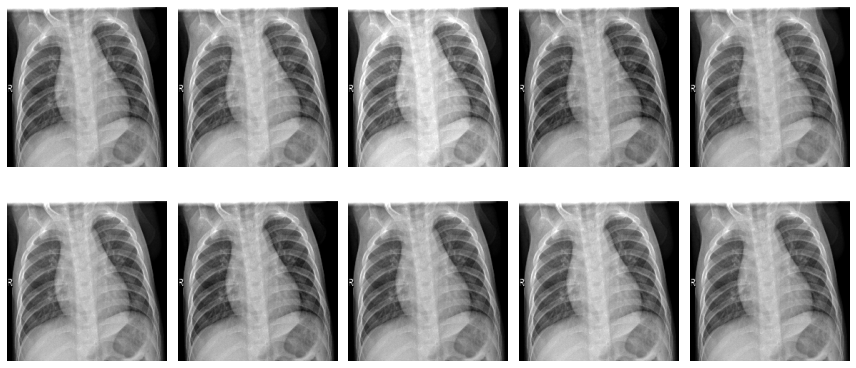

In [ ]:
### just in case of augumentation
#'''
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image[0,:,:],cmap='gray')
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

random.seed(42)
visualize_augmentations(train_dataset)
#'''

In [ ]:
image_datasets=  {'train': (train_dataset),
                 'validation': (val_dataset)
                 }

In [ ]:
batch_size =  64

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'validation':DataLoader(val_dataset, batch_size=batch_size, shuffle=True),
}
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### CREATING AND TRAINING MODEL

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
############## teste
class resnet50model(nn.Module):

  def __init__(self):
    super(resnet50model, self).__init__()
    self.feature_extractor = models.resnet50(pretrained = True)
    self.feature_extractor = torch.nn.Sequential(*(list(self.feature_extractor.children())[:-2]))

    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        nn.Flatten(),
        nn.Linear(2048, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 2)
        )
    self.gradient = None
  def activations_hook(self,grad):
    self.gradient = grad

  def forward(self,images):

    x = self.feature_extractor(images) ### feature maps / ACTIVATION MAPS
    h = x.register_hook(self.activations_hook)
    x = self.classifier(x)  ## top layers
    return x

  def get_activation_gradients(self): ##a1, a2, a3...ak
    return self.gradient

  def get_activation(self,x):   ### A1,A2,A3 .. ak
    return self.feature_extractor(x)

In [ ]:
model_resnet50 = resnet50model()
model_resnet50.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet50model(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [ ]:
total_pneumonia_images_train = glob.glob('/content/chest_xray/chest_xray/train/PNEUMONIA/*')
total_normal_images_train = glob.glob('/content/chest_xray/chest_xray/train/NORMAL/*')
ratio = len(total_normal_images_train)/len(total_pneumonia_images_train)
ratio

0.3460645161290323

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_test = torch.optim.Adam(model_resnet50.parameters(), lr = 0.001)

In [ ]:
def train_model(model, criterion, optimizer, path_to_save ,num_epochs=3,epoch_acc_max=0.75):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'validation':
              if epoch_acc > epoch_acc_max:
                epoch_acc_max = epoch_acc
                torch.save(model.state_dict(),path_to_save)


            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
path_to_save= '/content/gdrive/MyDrive/projects/model_pneumonia_resnet50.pt'

model_trained = train_model(model_resnet50, criterion, optimizer_test,path_to_save, num_epochs=10)


Epoch 1/10
----------
train loss: 0.1026, acc: 0.9634
validation loss: 0.0381, acc: 1.0000
Epoch 2/10
----------
train loss: 0.0838, acc: 0.9711
validation loss: 0.1307, acc: 0.9375
Epoch 3/10
----------
train loss: 0.0693, acc: 0.9735
validation loss: 0.2970, acc: 0.8750
Epoch 4/10
----------
train loss: 0.0783, acc: 0.9722
validation loss: 0.1278, acc: 0.9375
Epoch 5/10
----------
train loss: 0.0540, acc: 0.9810
validation loss: 0.0387, acc: 1.0000
Epoch 6/10
----------
train loss: 0.0547, acc: 0.9776
validation loss: 0.1002, acc: 0.9375
Epoch 7/10
----------
train loss: 0.0390, acc: 0.9845
validation loss: 0.1454, acc: 0.9375
Epoch 8/10
----------
train loss: 0.0302, acc: 0.9885
validation loss: 0.2351, acc: 0.9375
Epoch 9/10
----------
train loss: 0.0329, acc: 0.9877
validation loss: 0.2018, acc: 0.9375
Epoch 10/10
----------
train loss: 0.0204, acc: 0.9927
validation loss: 0.2237, acc: 0.9375


### Loading model

In [ ]:
############## teste
class resnet50model(nn.Module):

  def __init__(self):
    super(resnet50model, self).__init__()
    self.feature_extractor = models.resnet50(pretrained = True)
    self.feature_extractor = torch.nn.Sequential(*(list(self.feature_extractor.children())[:-2]))

    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        nn.Flatten(),
        nn.Linear(2048, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 2)
        )
    self.gradient = None
  def activations_hook(self,grad):
    self.gradient = grad

  def forward(self,images):

    x = self.feature_extractor(images) ### feature maps / ACTIVATION MAPS
    h = x.register_hook(self.activations_hook)
    x = self.classifier(x)  ## top layers
    return x

  def get_activation_gradients(self): ##a1, a2, a3...ak
    return self.gradient

  def get_activation(self,x):   ### A1,A2,A3 .. ak
    return self.feature_extractor(x)

In [ ]:
model_resnet50_loaded = resnet50model()
PATH_SAVED_MODEL_1= '/content/gdrive/MyDrive/projects/model_pneumonia_resnet50.pt'

model_resnet50_loaded.load_state_dict(torch.load(PATH_SAVED_MODEL_1,map_location = device))
model_resnet50_loaded.to(device)
model_resnet50_loaded.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet50model(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

**TEST DATASET**

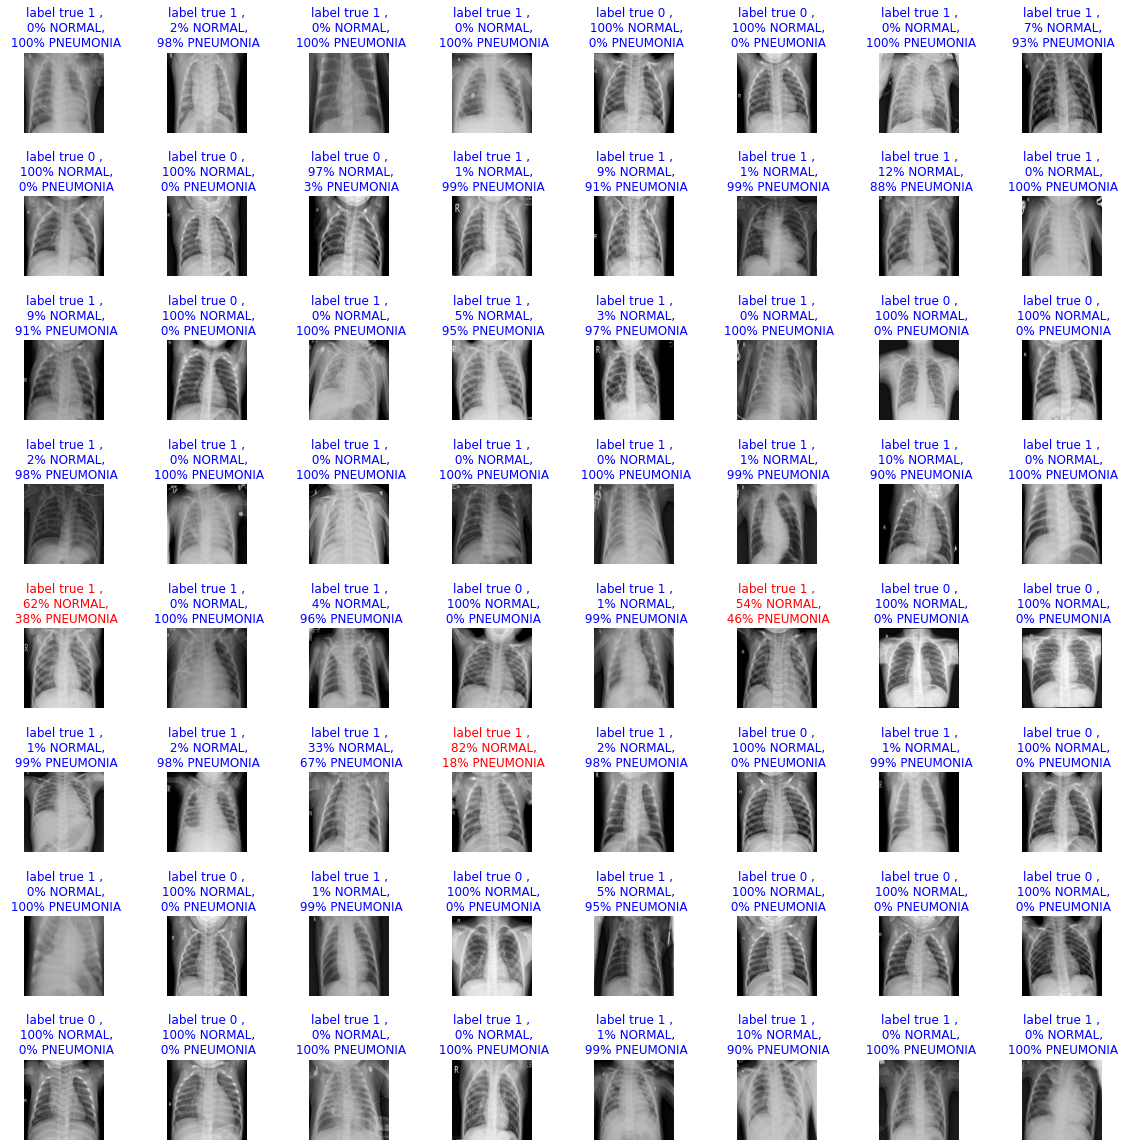

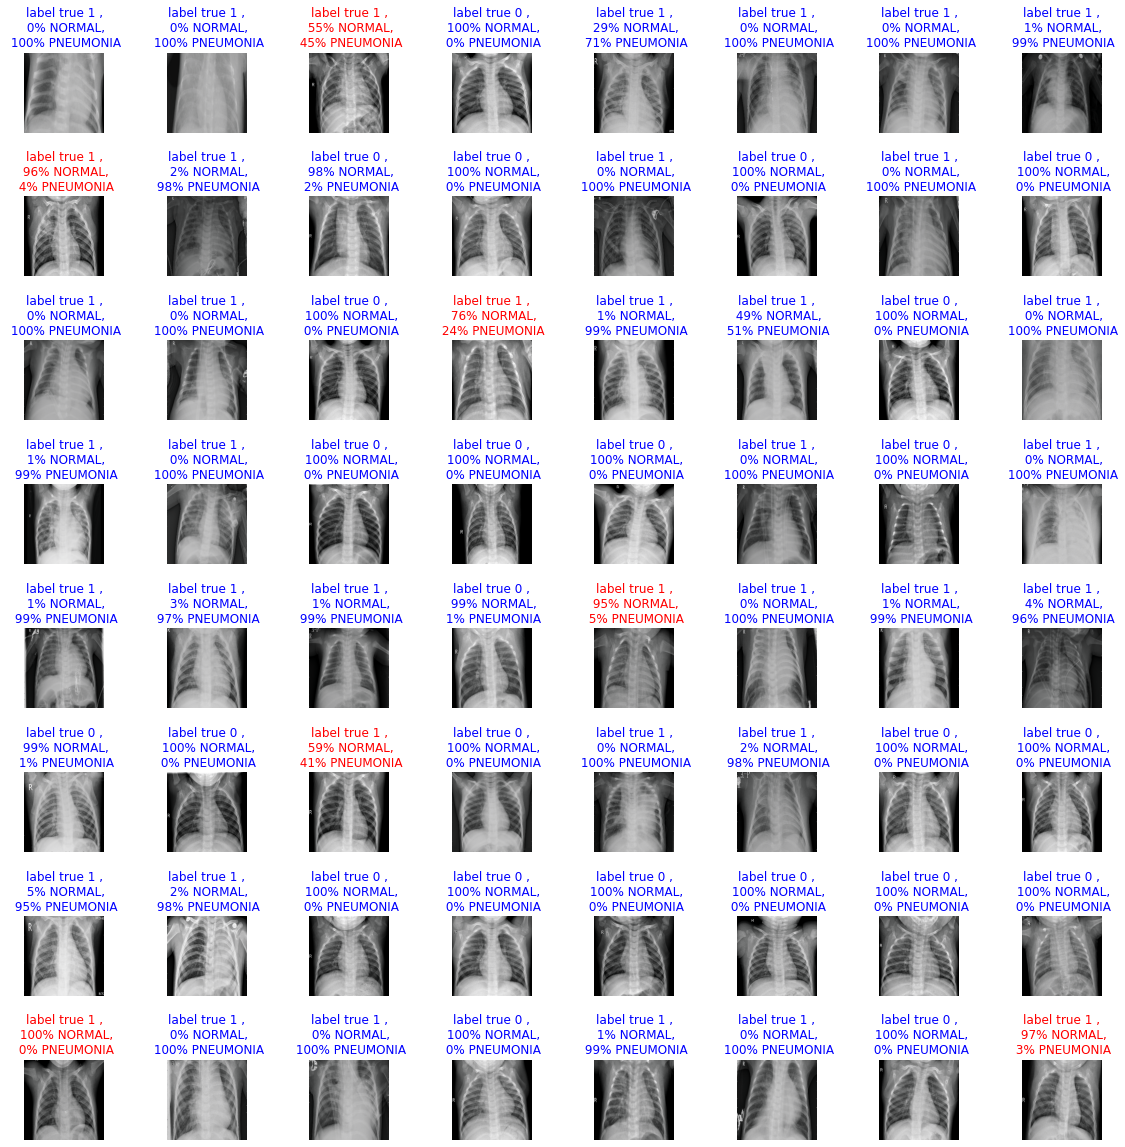

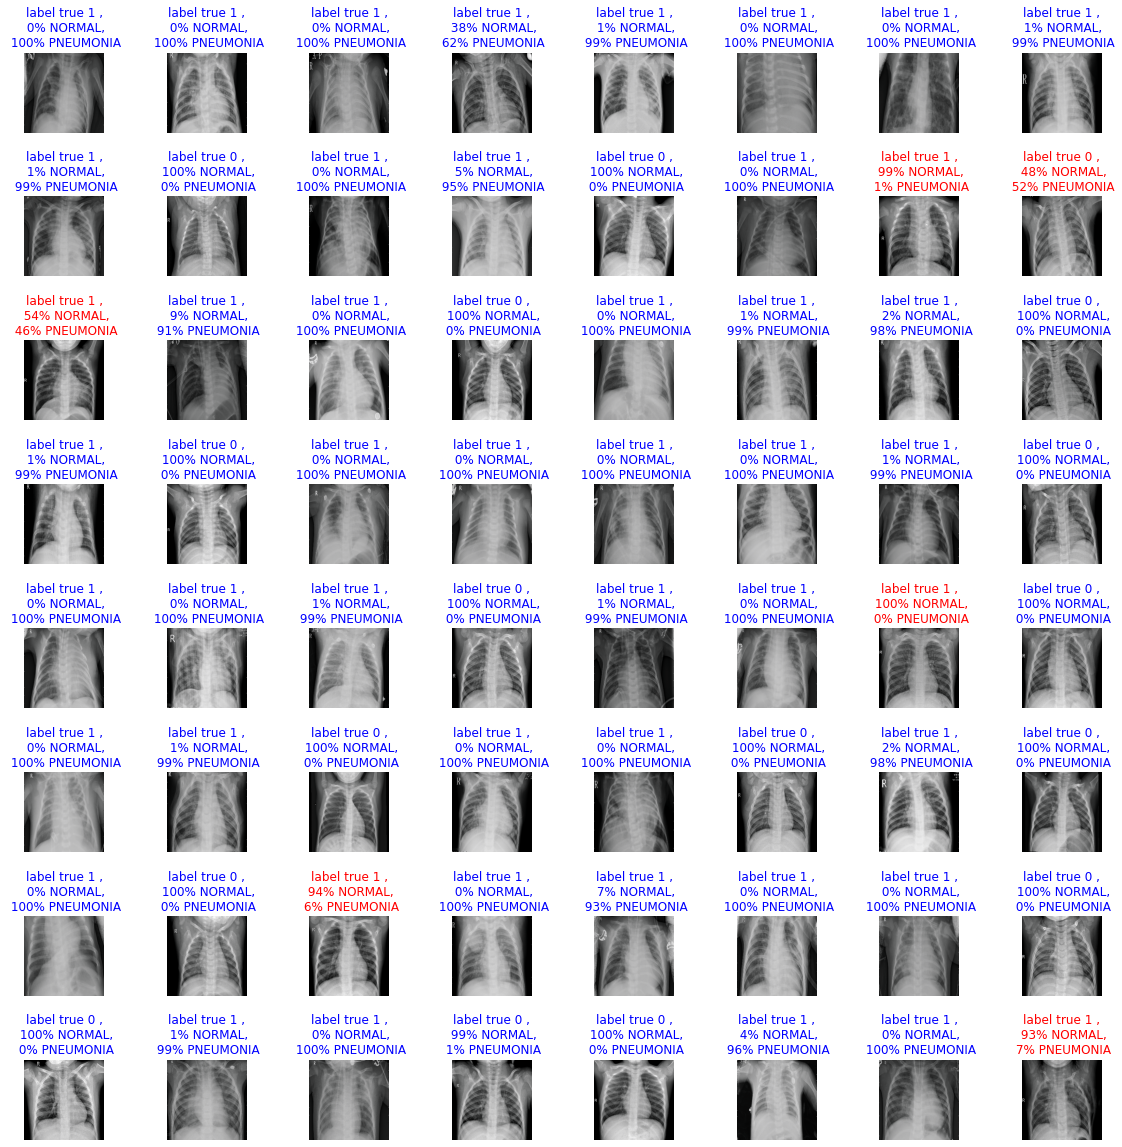

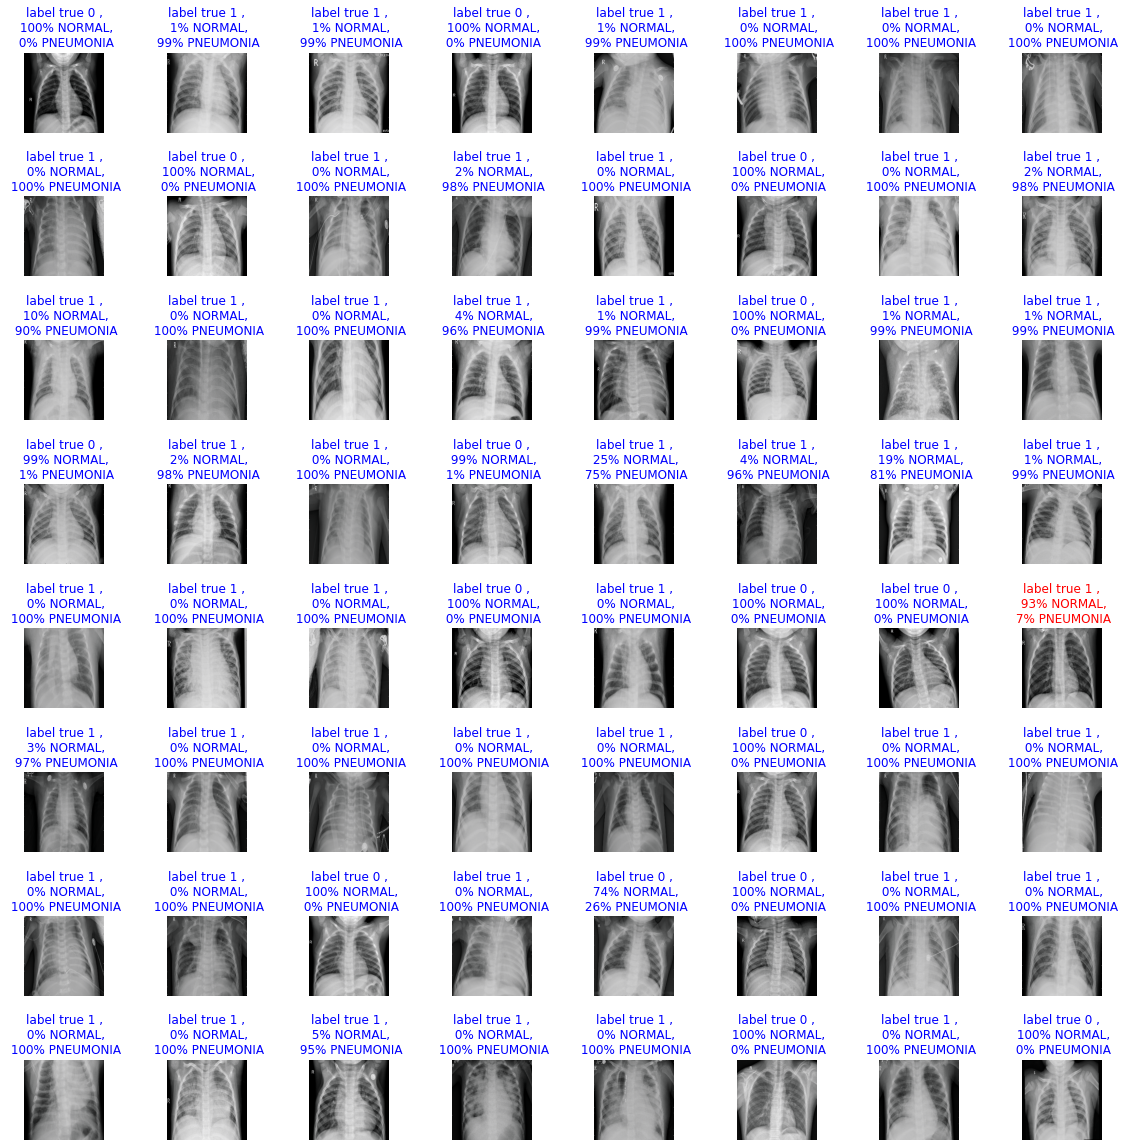

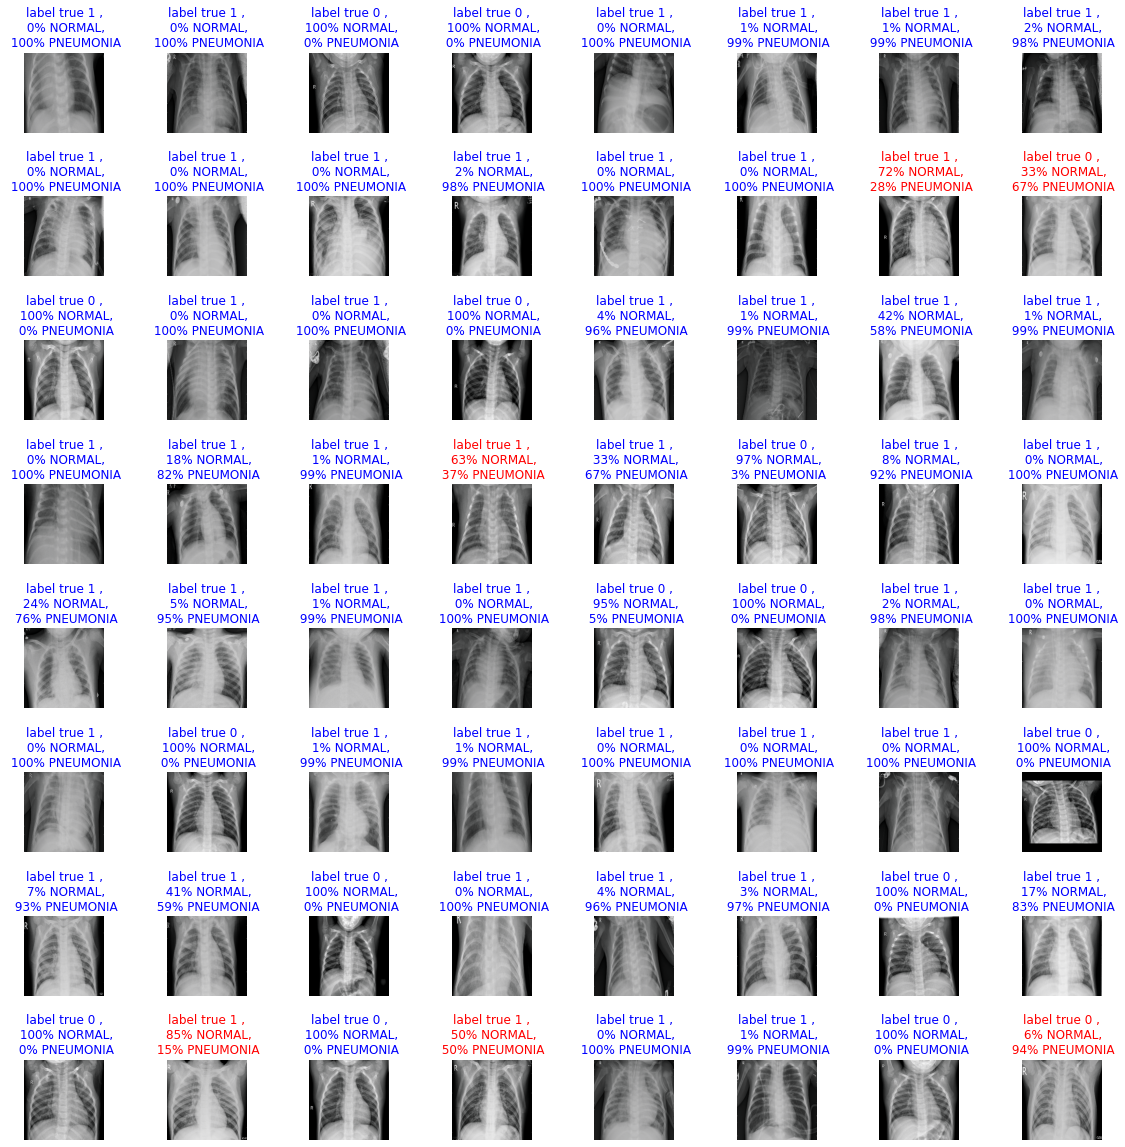

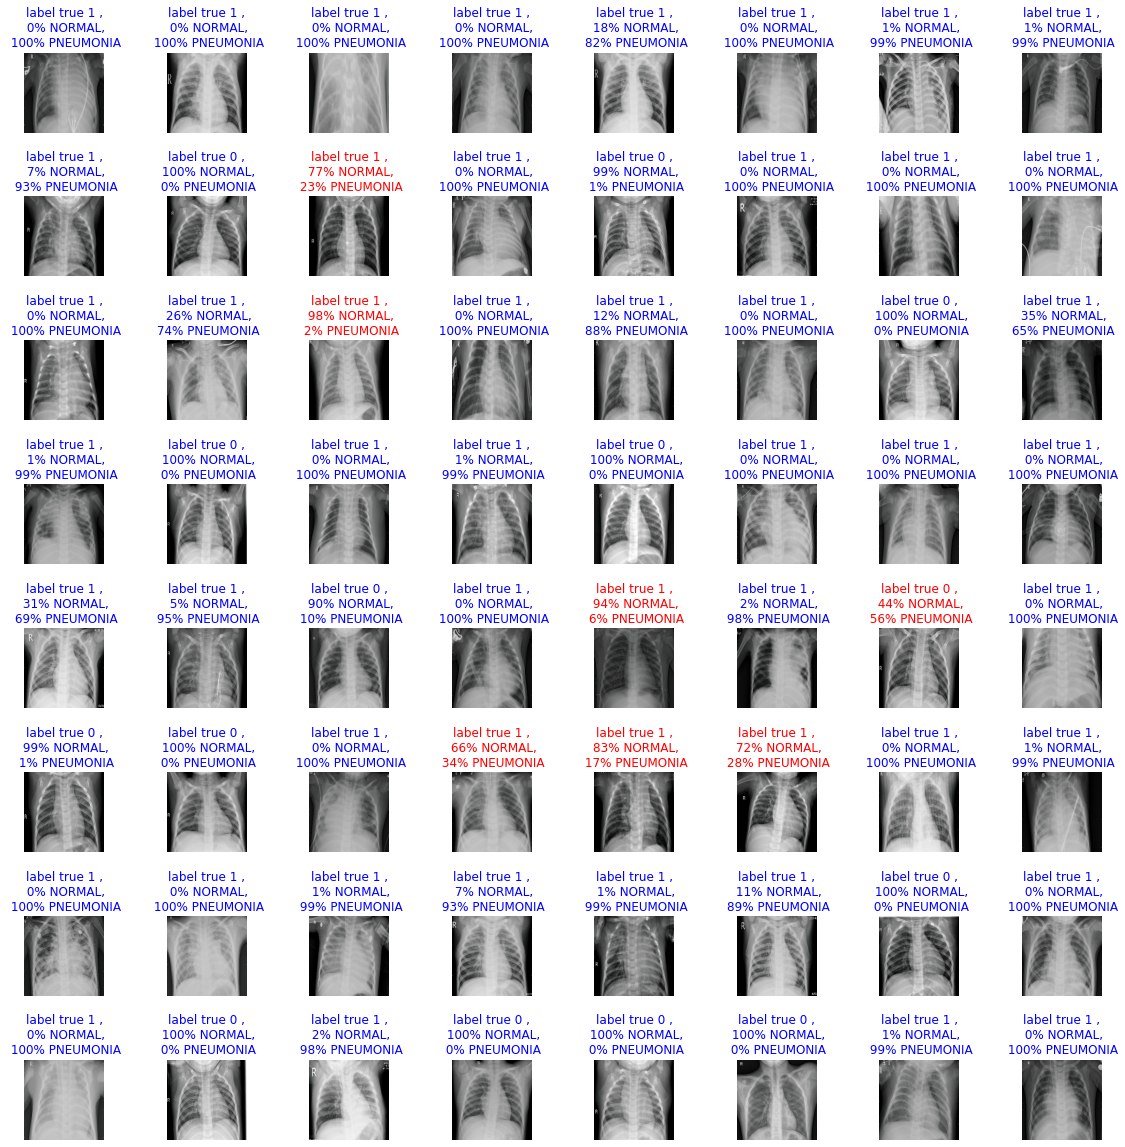

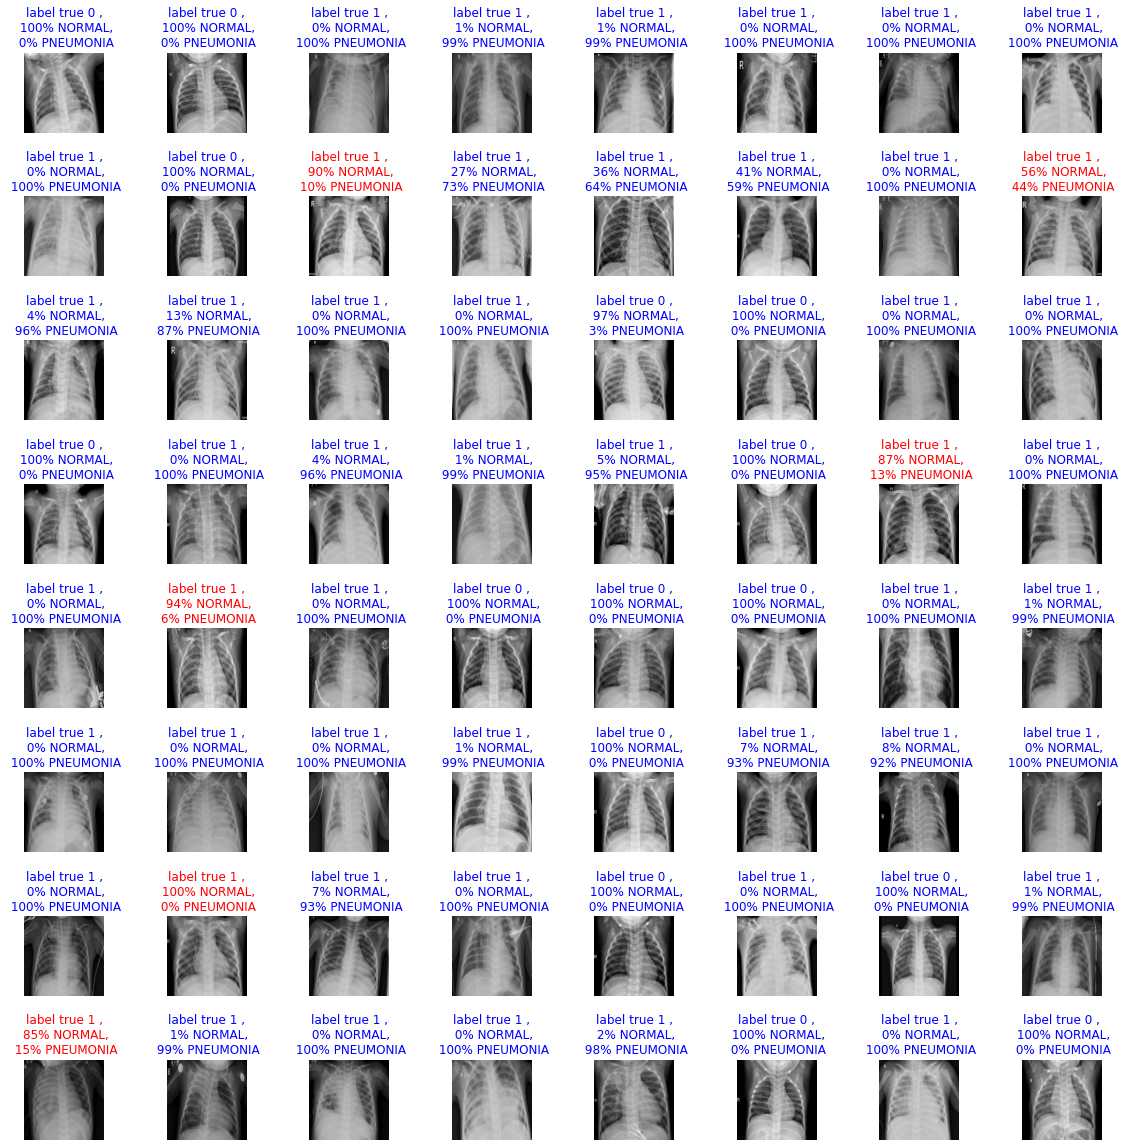

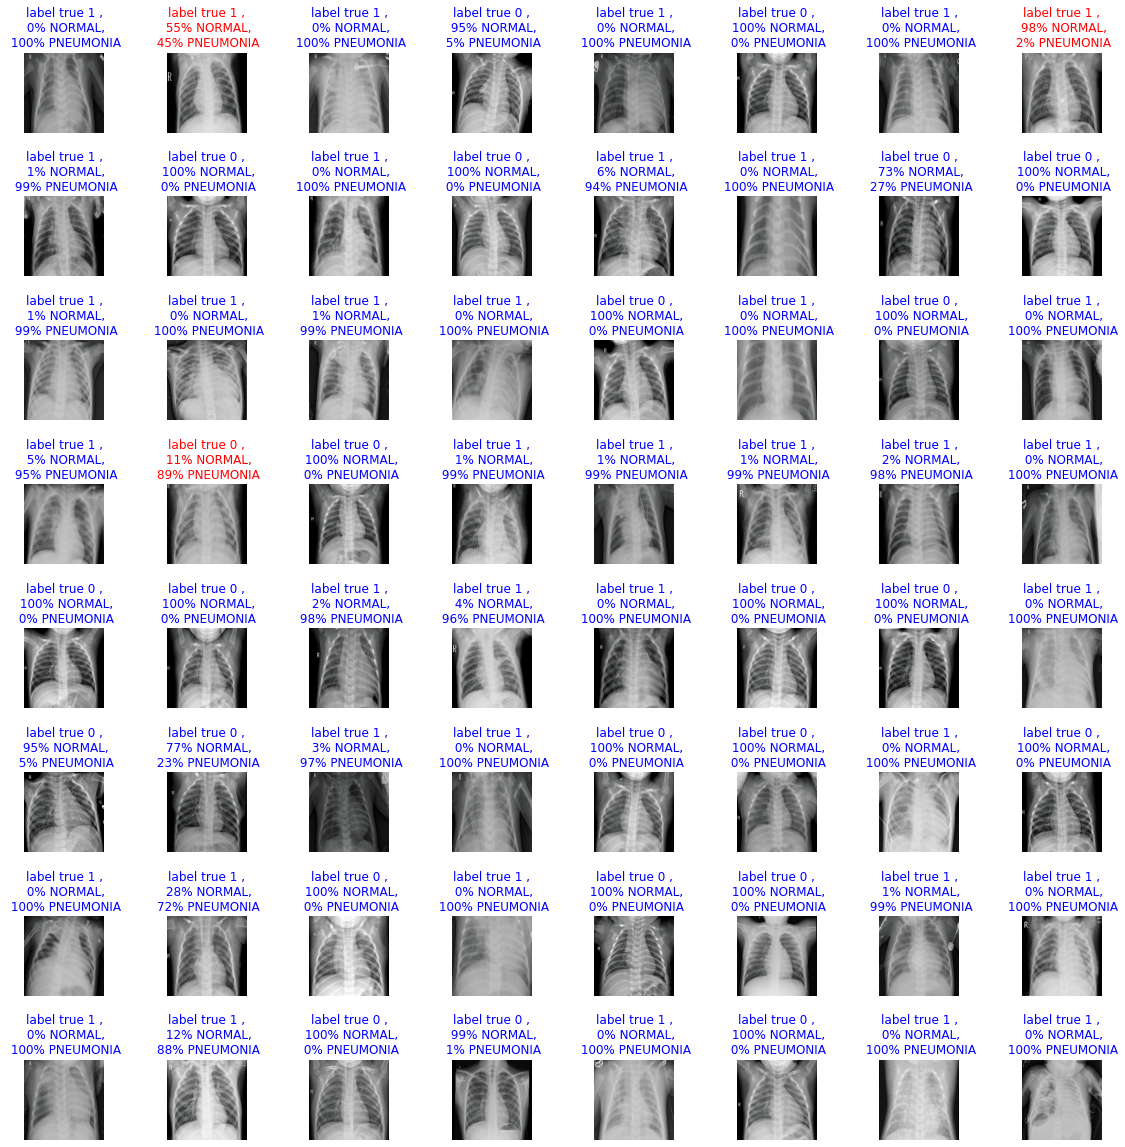

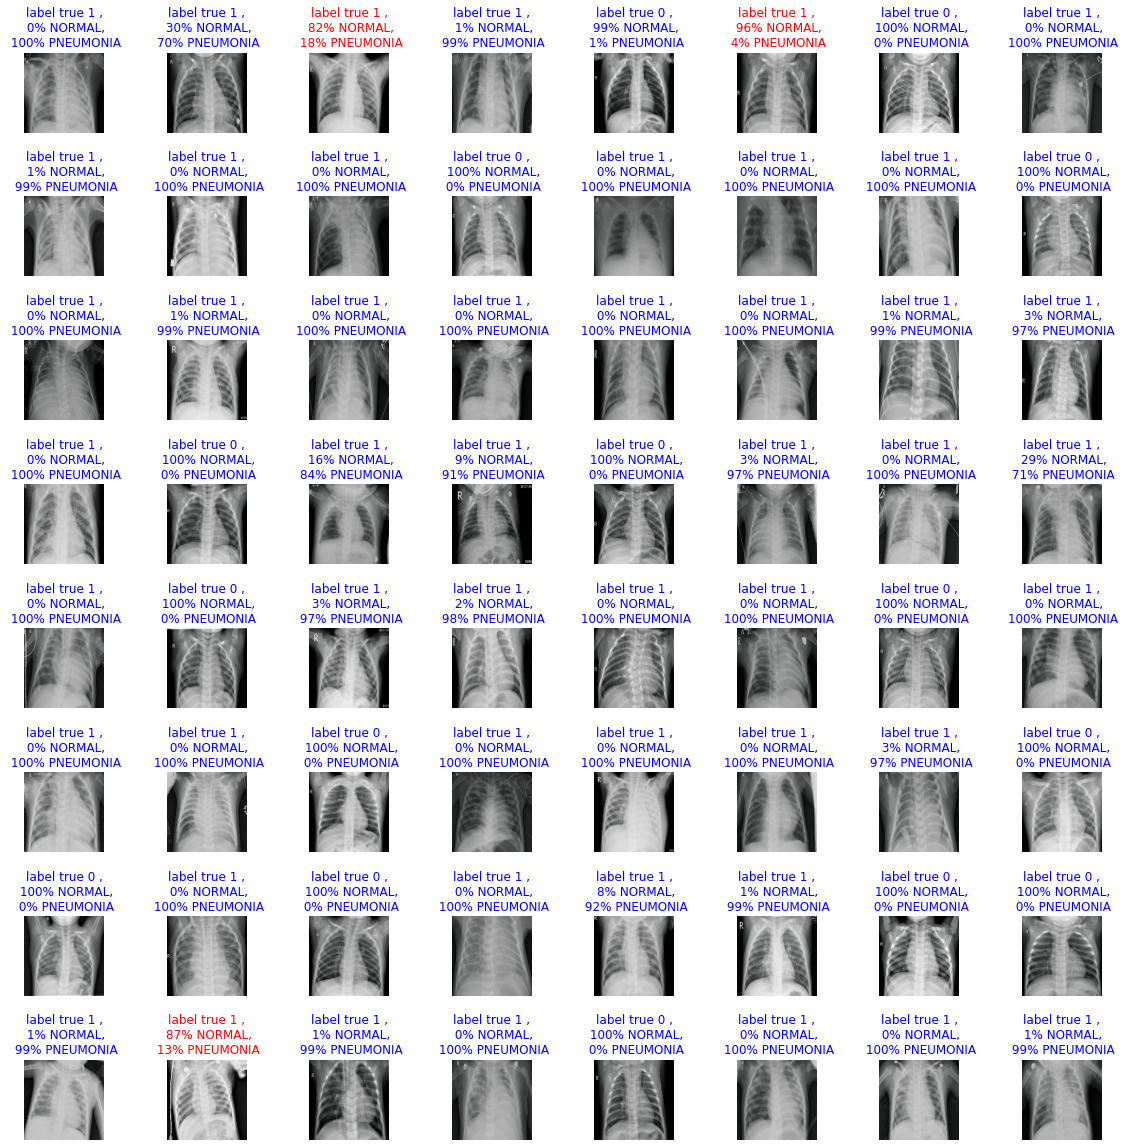

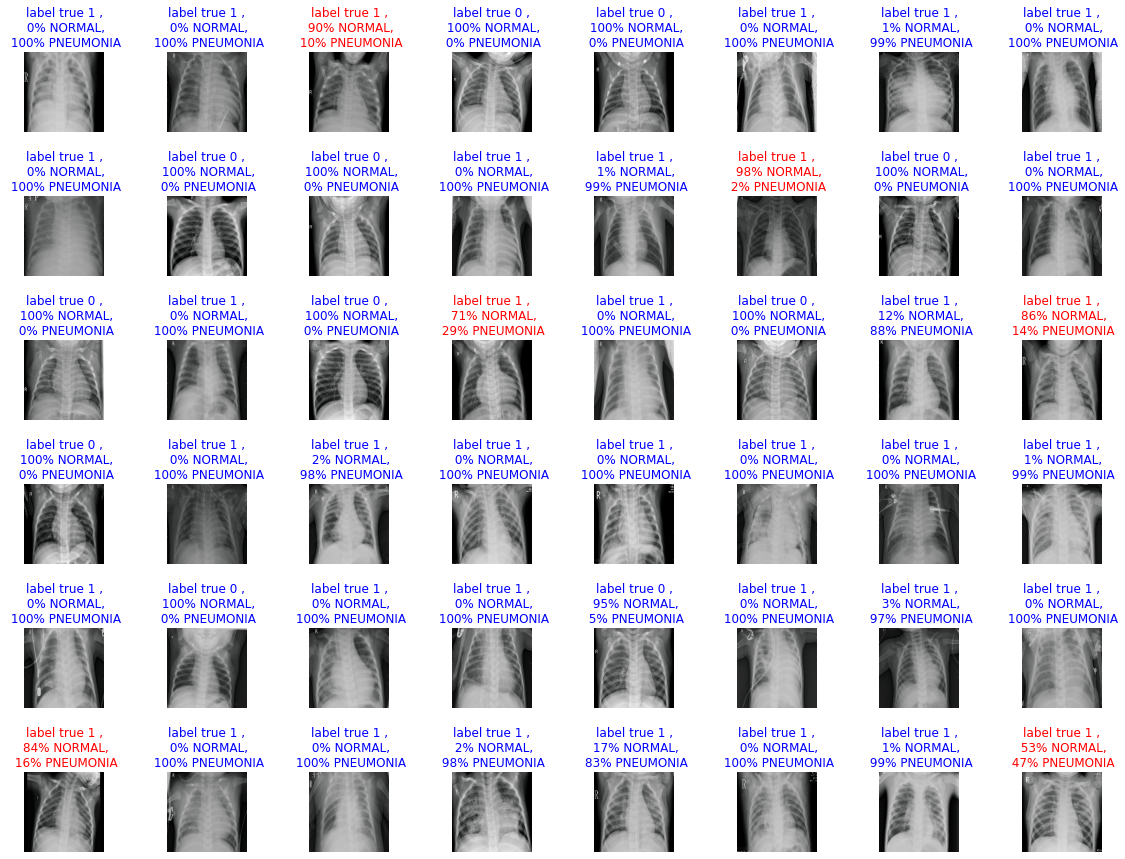

f1_result 0.9443155452436195


<Figure size 432x288 with 0 Axes>

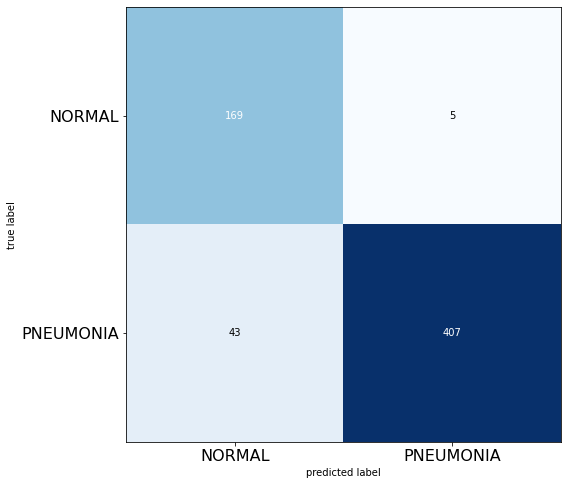

In [ ]:
def undo_norm(image):
  npimg = ((image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406])
  return npimg

label_numpy_list =[]
predics_numpy_list = []
for inputs, labels in test_dataloader:
  inputs = inputs.to(device)
  labels = labels.type(torch.LongTensor)
  labels = labels.to(device)
  predicted = model_resnet50_loaded(inputs)
  _,preds = torch.max(predicted, 1)

  label_numpy = labels.cpu().numpy().tolist()
  predics_numpy = preds.cpu().detach().numpy().tolist()

  pred_probs = torch.softmax(predicted, dim=1).cpu().data.numpy()

  plt.figure(figsize=(20,20))
  for i, img in enumerate(inputs):
      #ax = axs[i]
      ax = plt.subplot(8,8,i+1)
      plt.subplots_adjust( 
                    hspace=0.8
                    )
      ax.axis('off')

      if labels[i] == preds[i]:
        color = 'blue'

      else:
        color ='red'
      ax.set_title("label true {:.0f} ,\n {:.0f}% NORMAL,\n {:.0f}% PNEUMONIA".format(labels[i],100*pred_probs[i,0],
                                                              100*pred_probs[i,1]),color = color)
      img = np.transpose(img.cpu(),(1,2,0)).numpy()
      img = undo_norm(img)
      ax.imshow((img*255).astype(np.uint8),cmap='gray')#(img*255).astype(np.uint8)
  

  label_numpy_list = label_numpy_list + label_numpy
  predics_numpy_list = predics_numpy_list + predics_numpy

  plt.show() 

f1_result = f1_score(predics_numpy_list,label_numpy_list)
print('f1_result',f1_result)

cm  = confusion_matrix(label_numpy_list, predics_numpy_list)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True)
plt.xticks(range(2), ['NORMAL','PNEUMONIA'], fontsize=16)
plt.yticks(range(2), ['NORMAL','PNEUMONIA'], fontsize=16)
plt.show()
